In [2]:
# import statements.
import datetime
import glob
import json
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import seaborn as sbs
import random
import tensorflow_hub as hub
import tensorflow as tf
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
LONG_TOUCH_THRESHOLD = 5
MAX_TOKEN = 64
DIM_X = 1440
DIM_Y = 2560
IMG_DIM = 224
PLACEHOLDER_IMG = 'Blank.jpg'
VAL_SIZE = 0.1
TEST_SIZE = 0.1
BATCH_SIZE = 10
TRACES_PATH = 'filtered_traces/com.google.android*/*'

In [4]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

model = hub.KerasLayer(MODULE_HANDLE)

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [5]:
Image.MAX_IMAGE_PIXELS = None

# Gets all leaf nodes for a given element.
def get_leaf_nodes(element, leaf_nodes):
    if not element:
        return leaf_nodes
    if 'children' not in element:
        leaf_nodes.append(element)
        return leaf_nodes
    for child in element['children']:
        get_leaf_nodes(child, leaf_nodes)
    return leaf_nodes


def get_all_leaf_nodes(view_hierarchy_json):
    activity = view_hierarchy_json.get('activity')
    if not activity:
        return dataset
    root = activity.get('root')
    return get_leaf_nodes(root, [])


def get_target_image(screenshot, leaf_nodes, x, y):
    target_image = None
    for leaf_node in leaf_nodes:
        bounds = leaf_node['bounds']
        if bounds[0] <= x and bounds[2] >= x and bounds[1] <= y and bounds[3] >= y:
            temp_image = screenshot.crop(bounds)
            target_image = temp_image.resize((IMG_DIM, IMG_DIM), Image.ANTIALIAS)
            break   
    return target_image


def get_target_image_index(screenshot, leaf_nodes, x, y):
    i = 0
    for leaf_node in leaf_nodes:
        bounds = leaf_node['bounds']
        if bounds[0] <= x and bounds[2] >= x and bounds[1] <= y and bounds[3] >= y:
            return i
        i += 1
    return -1


def get_leaf_node_images(screenshot, leaf_nodes):
    i = 0
    element_images = []
    for leaf_node in leaf_nodes:
        bounds = leaf_node['bounds']
        temp_image = screenshot
        image = temp_image.crop(bounds)
        resized_image = image.resize((IMG_DIM, IMG_DIM), Image.ANTIALIAS)
        element_images.append(resized_image)
        i += 1
        if i == MAX_TOKEN:
            break
    return element_images


def get_image_embeddings(images):
    image_list = []
    for image in images:
        temp = transforms.ToTensor()(image)
        image = tf.transpose(temp, perm=[2, 1, 0])
        image_list.append(image)
    
    embeddings = model(image_list)
    return embeddings


def get_labels_tensor(target_index):
    if target_index >= 0:
        st = tf.sparse.SparseTensor(indices=[[target_index, 0]], values=[1], dense_shape=[MAX_TOKEN, 1])
        return tf.sparse.to_dense(st)
    else:
        return tf.zeros([MAX_TOKEN, 1])
    

# Identifies if a given gesture is a TOUCH gesture.
# In this task, we will only be focussing on TOUCH gestures.
def is_touch_gesture(gesture):
    if len(gesture) <= LONG_TOUCH_THRESHOLD:
        return True
    return False

In [97]:
# Single Trace Visualization.

from PIL import Image

view_hierarchy1 = 'filtered_traces/aero.sita.lab.resmobileweb.android.mh/trace_0/view_hierarchies/526.json'
view_hierarchy2 = 'filtered_traces/aero.sita.lab.resmobileweb.android.mh/trace_0/view_hierarchies/614.json'

trace_path = view_hierarchy1.split('view_hierarchies')[0]
gesture_path = f'{trace_path}/gestures.json'
with open(gesture_path) as file:
    gestures = json.load(file)
    
with open(view_hierarchy1) as file:
    view_hierarchy1_json = json.load(file)
with open(view_hierarchy2) as file:
    view_hierarchy2_json = json.load(file)
    
ui_number = view_hierarchy1.split('/')[-1].split('.')[0]
gesture = gestures[ui_number]

if not is_touch_gesture(gesture):
    print('not a touch gesture')
    
screenshot1_path = f'{trace_path}/screenshots/{ui_number}.jpg'
trace_path2 = view_hierarchy2.split('view_hierarchies')[0]
ui_number2 = view_hierarchy2.split('/')[-1].split('.')[0]
screenshot2_path = f'{trace_path2}/screenshots/{ui_number2}.jpg'

# Plot the screenshot with position where click(tap) was performed.
screenshot1 = PIL.Image.open(screenshot1_path)
screenshot2 = PIL.Image.open(screenshot2_path)

if not screenshot1 or not screenshot2:
    print('do not find screenshot')

# The size of the screenshot is 1080 * 1920.
# Rescaling it to 1440 * 2560, dimension used by view hierarchy data.
resized_screenshot1 = screenshot1.resize((DIM_X, DIM_Y), Image.ANTIALIAS)
resized_screenshot2 = screenshot2.resize((DIM_X, DIM_Y), Image.ANTIALIAS)

x_cord = gesture[0][0]
y_cord = gesture[0][1]
x = x_cord * DIM_X
y = y_cord * DIM_Y

leaf_nodes1 = get_all_leaf_nodes(view_hierarchy1_json)
leaf_nodes2 = get_all_leaf_nodes(view_hierarchy2_json)

# target_image = get_target_image(resized_screenshot1, leaf_nodes1, x, y)
# if not target_image:
#     print('Do not find target image')

target_image_index = get_target_image_index(resized_screenshot1, leaf_nodes1, x, y)
if target_image_index == -1 or target_image_index >= MAX_TOKEN:
    print('target image index not correct')
    
screen1_element = get_leaf_node_images(resized_screenshot1, leaf_nodes1)
screen2_element = get_leaf_node_images(resized_screenshot2, leaf_nodes2)

placeholder = PIL.Image.open(PLACEHOLDER_IMG)
resized_placeholder = placeholder.resize((IMG_DIM, IMG_DIM), Image.ANTIALIAS)

for i in range(len(screen1_element), MAX_TOKEN):
    screen1_element.append(resized_placeholder)
for i in range(len(screen2_element), MAX_TOKEN):
    screen2_element.append(resized_placeholder)
    
image_embeddings = get_image_embeddings(screen1_element + screen2_element)

label = 0
dataset=[]

entry=[]
entry.append(image_embeddings)
entry.append(labels)
entry.append(label)
dataset.append(entry)

target image index not correct


NameError: name 'labels' is not defined

In [6]:
# Processes view hierarchies to construct dataset.
# Extract texts from MAX_TOKEN elements from both view hierarchies.
# Construct the dataset in the following format -
# [[e11, e21, ... e1(MAX_TOKEN), e21, e22, ... e2(MAX_TOKEN), TARGET_TEXT], ...]
def process_view_hierarchy(view_hierarchy1, view_hierarchy2, dataset, is_positive_sample = True):
    if not view_hierarchy1 or not view_hierarchy2:
        return dataset
    
    trace_path = view_hierarchy1.split('view_hierarchies')[0]
    gesture_path = f'{trace_path}/gestures.json'
    with open(gesture_path) as file:
        gestures = json.load(file)

    with open(view_hierarchy1) as file:
        view_hierarchy1_json = json.load(file)
    with open(view_hierarchy2) as file:
        view_hierarchy2_json = json.load(file)
    
    if not view_hierarchy1_json or not view_hierarchy2_json:
        return dataset

    ui_number = view_hierarchy1.split('/')[-1].split('.')[0]
    gesture = gestures[ui_number]
    if not is_touch_gesture(gesture):
        return dataset
    
    if not len(gesture):
        return dataset
    
    screenshot1_path = f'{trace_path}/screenshots/{ui_number}.jpg'
    trace_path2 = view_hierarchy2.split('view_hierarchies')[0]
    ui_number2 = view_hierarchy2.split('/')[-1].split('.')[0]
    screenshot2_path = f'{trace_path2}/screenshots/{ui_number2}.jpg'
    
    # Plot the screenshot with position where click(tap) was performed.
    screenshot1 = PIL.Image.open(screenshot1_path)
    screenshot2 = PIL.Image.open(screenshot2_path)
    
    if not screenshot1 or not screenshot2:
        return dataset
    
    # The size of the screenshot is 1080 * 1920.
    # Rescaling it to 1440 * 2560, dimension used by view hierarchy data.
    resized_screenshot1 = screenshot1.resize((DIM_X, DIM_Y), Image.ANTIALIAS)
    resized_screenshot2 = screenshot2.resize((DIM_X, DIM_Y), Image.ANTIALIAS)
    
    x_cord = gesture[0][0]
    y_cord = gesture[0][1]
    x = x_cord * DIM_X
    y = y_cord * DIM_Y

    leaf_nodes1 = get_all_leaf_nodes(view_hierarchy1_json)
    leaf_nodes2 = get_all_leaf_nodes(view_hierarchy2_json)

    target_image_index = get_target_image_index(resized_screenshot1, leaf_nodes1, x, y)
    if target_image_index == -1 or target_image_index >= MAX_TOKEN:
        return dataset
    
    screen1_element = get_leaf_node_images(resized_screenshot1, leaf_nodes1)
    screen2_element = get_leaf_node_images(resized_screenshot1, leaf_nodes2)

    placeholder = PIL.Image.open(PLACEHOLDER_IMG)
    resized_placeholder = placeholder.resize((IMG_DIM, IMG_DIM), Image.ANTIALIAS)
    for i in range(len(screen1_element), MAX_TOKEN):
        screen1_element.append(resized_placeholder)
    for i in range(len(screen2_element), MAX_TOKEN):
        screen2_element.append(resized_placeholder)
        
    image_embeddings = get_image_embeddings(screen1_element + screen2_element)
    
    if is_positive_sample:
        labels = get_labels_tensor(target_image_index)
        label = 1
    else:
        labels = get_labels_tensor(-1)
        label = 0
        
    entry=[]
    entry.append(image_embeddings)
    entry.append(labels)
    entry.append(label)
    dataset.append(entry)
    return dataset
        

def process_trace(trace_path, dataset):
    view_hierarchies_path = f'{trace_path}/view_hierarchies/*'
    view_hierarchies = sorted(glob.glob(view_hierarchies_path))
    for i in range(len(view_hierarchies) - 1):
        dataset = process_view_hierarchy(view_hierarchies[i], view_hierarchies[i+1], dataset)


def add_negative_samples(dataset):
    traces = sorted(glob.glob(TRACES_PATH))
    total_positive_samples = len(dataset)
    negative_samples_threshold = 0.1 * total_positive_samples
    negative_samples_counter = 0
    for i in range(len(traces) - 1):
        trace_path1 = traces[i]
        trace_path2 = traces[i+1]
        view_hierarchies1_path = sorted(glob.glob(f'{trace_path1}/view_hierarchies/*'))
        view_hierarchies2_path = sorted(glob.glob(f'{trace_path2}/view_hierarchies/*'))
        for (view_hierarchy1, view_hierarchy2) in zip(view_hierarchies1_path, view_hierarchies2_path):
            dataset = process_view_hierarchy(view_hierarchy1, view_hierarchy2, dataset, False)
            negative_samples_counter += 1
            if negative_samples_counter >= negative_samples_threshold:
                break
    return dataset

dataset = []
for trace_path in sorted(glob.glob(TRACES_PATH)):
    process_trace(trace_path, dataset)

dataset = add_negative_samples(dataset)

In [7]:
total_positive_samples = len(dataset)
negative_samples_threshold = 0.1 * total_positive_samples
negative_samples_threshold

23.0

In [8]:
def map_to_dataset(dataset):
    labels = []
    input_data = []
    for input_instance in dataset:
        input_data.append(tf.reshape(input_instance[0], [-1]))
        labels.append(tf.reshape(tf.dtypes.cast(input_instance[1], tf.int32), [-1]))
    return tf.data.Dataset.from_tensor_slices((input_data, labels))

In [9]:
def map_to_dataset_classification(dataset):
    label = []
    input_data = []
    for input_instance in dataset:
        input_data.append(tf.reshape(input_instance[0], [-1]))
        label.append(tf.reshape(tf.dtypes.cast(input_instance[2], tf.int32), [-1]))
    return tf.data.Dataset.from_tensor_slices((input_data, label))

In [10]:
train, test = train_test_split(dataset, test_size=TEST_SIZE)
train, val = train_test_split(dataset, test_size=VAL_SIZE)

In [11]:
train = map_to_dataset(train).batch(BATCH_SIZE)
val = map_to_dataset(val).batch(BATCH_SIZE)
test = map_to_dataset(test).batch(BATCH_SIZE)
data = map_to_dataset(dataset).batch(BATCH_SIZE)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=MAX_TOKEN, activation='softmax')
])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam'),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train, validation_data=val, epochs=50, callbacks=[tensorboard_callback], batch_size=BATCH_SIZE)



Epoch 1/50
 1/21 [>.............................] - ETA: 0s - loss: 3.7390 - accuracy: 0.0000e+00WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


21/21 [==============================] - 3s 166ms/step - loss: 3.3554 - accuracy: 0.0966 - val_loss: 2.7208 - val_accuracy: 0.1739
Epoch 2/50
21/21 [==============================] - 3s 147ms/step - loss: 2.7735 - accuracy: 0.2367 - val_loss: 2.5471 - val_accuracy: 0.3043
Epoch 3/50
21/21 [==============================] - 3s 155ms/step - loss: 2.3495 - accuracy: 0.3140 - val_loss: 2.4645 - val_accuracy: 0.2609
Epoch 4/50
21/21 [==============================] - 3s 158ms/step - loss: 1.9825 - accuracy: 0.3961 - val_loss: 2.3631 - val_accuracy: 0.2174
Epoch 5/50
21/21 [==============================] - 3s 152ms/step - loss: 1.6132 - accuracy: 0.4879 - val_loss: 2.3003 - val_accuracy: 0.2174
Epoch 6/50
21/21 [==============================] - 3s 152ms/step - loss: 1.3487 - accuracy: 0.5749 - val_loss: 2.2862 - val_accuracy: 0.2174
Epoch 7/50
21/21 [==============================] - 3s 161ms/step - loss: 1.1083 - accuracy: 0.6522 - val_loss: 2.2557 - val_accuracy: 0.2609
Epoch 8/50
21/21 

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(15.0, 10.0)

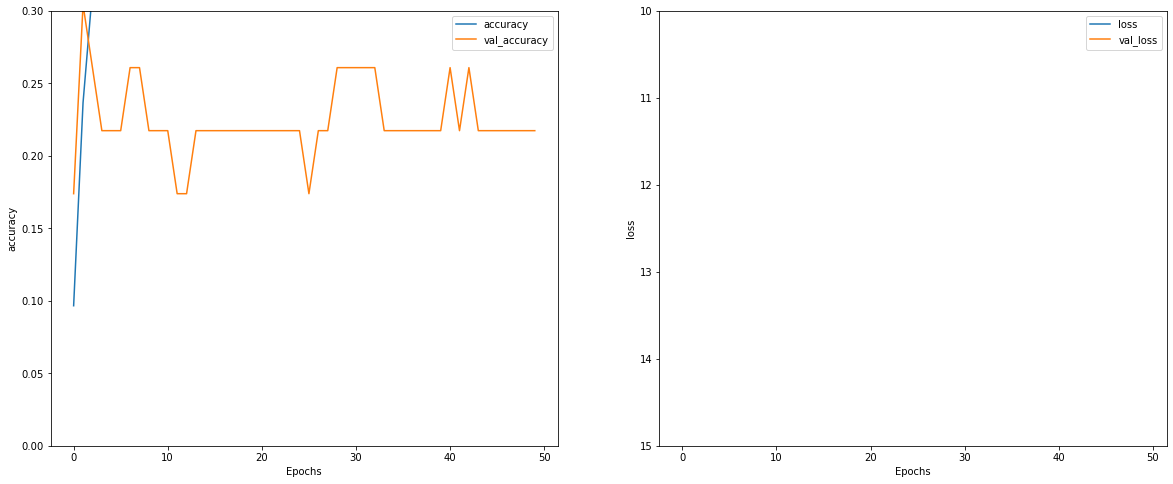

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(0,0.3)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(15, 10)